In [2]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [500]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=32,
    sample_size=1000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.2,
    output_channel_index=0,
    output_size=(128,128))



Found 800 files for Training set
Found 200 files for Test set


In [454]:
img_width = 128
img_height = 128
kernel_size = 5
strides = 2


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim, num_channels):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, num_channels), filters=32, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim,)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=8192, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(8,4,256)),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=num_channels, kernel_size=kernel_size, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(512, 1)

opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [401]:
for layer in autoencoder.layers:
    print(layer.summary())

Model: "sequential_239"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_443 (Conv2D)         (None, 64, 32, 32)        832       
                                                                 
 batch_normalization_1073 (B  (None, 64, 32, 32)       128       
 atchNormalization)                                              
                                                                 
 conv2d_444 (Conv2D)         (None, 32, 16, 64)        51264     
                                                                 
 batch_normalization_1074 (B  (None, 32, 16, 64)       256       
 atchNormalization)                                              
                                                                 
 conv2d_445 (Conv2D)         (None, 16, 8, 128)        204928    
                                                                 
 batch_normalization_1075 (B  (None, 16, 8, 128)    

In [402]:
# autoencoder.load_weights('data/autoencoder_128dim_512f_tanh')

In [403]:
hist_2 = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=10,
                       validation_data=data_gen.test)

Epoch 1/10
122/306 [==========>...................] - ETA: 1:09 - loss: 0.0138

KeyboardInterrupt: 

In [178]:
autoencoder_path = 'data/autoencoder_128dim_1024f_tanh'
autoencoder.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_128dim_512f_tanh/assets


INFO:tensorflow:Assets written to: data/autoencoder_128dim_512f_tanh/assets


In [485]:
prediction_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512),
    color_mode='rgb',
    batch_size=1,
    shuffle=False,
    output_channel_index=0,
    output_size=(128,128))

Found 278326 files for Generator set


<Figure size 1440x360 with 0 Axes>

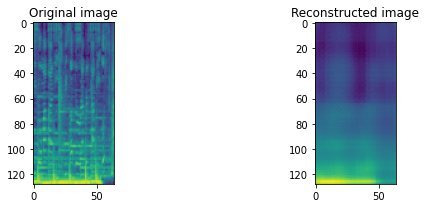

In [397]:
from src.helper_functions import plot_reconstruction
import matplotlib.pyplot as plt

test_img = prediction_gen.take(0)[0]
prediction = autoencoder(test_img)

plt.figure(figsize=(20,5))

plot_reconstruction(test_img, prediction, 1)

In [187]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather', latent_dims=128, output_size=(128, 128)
                        )

Found 278326 files for Generator set


In [188]:
latent_space.build()


Getting predictions from autoencoder...
[============================================================>] 8697 / 8697

24.43 minutes elapsed
Building tracks dataframe...
size of results 1113216
Track dataframe built. 14.56 minutes elapsed
Building artist distributions...
Artist distributions built. 0.0 minutes elapsed
Building genre distributions...
Genre distributions built. 2.43 minutes elapsed
Latent Space Built.


FileNotFoundError: [Errno 2] Failed to open local file 'data/latent_space_128dim_512f_tanh//tracks.feather'. Detail: [errno 2] No such file or directory

In [198]:
try:
    os.mkdir('data/latent_space_128dim_512f_tanh')
except:
    pass
latent_space.save('data/latent_space_128dim_512f_tanh')

In [218]:
data_gen.take(1)[0][0].shape

(128, 128, 1)

In [240]:
kernel_size = 5

class Autoencoder2(tf.keras.Model):
    
    def __init__(self, latent_dim, num_channels):
        super(Autoencoder2, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Reshape(target_shape=(128,128)),
            tf.keras.layers.Conv1D(input_shape=(img_height, img_width), filters=256, kernel_size=3, padding="same", strides=1, activation='relu'),
            tf.keras.layers.MaxPool1D(pool_size=2),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", strides=1, activation='relu'),
            tf.keras.layers.MaxPool1D(pool_size=2),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", strides=1, activation='relu'),
            tf.keras.layers.MaxPool1D(pool_size=2),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=8192, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(16,512)),
            tf.keras.layers.UpSampling1D(size=2),
            tf.keras.layers.Conv1DTranspose(filters=512, kernel_size=3, strides=1, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            tf.keras.layers.UpSampling1D(size=2),
            tf.keras.layers.Conv1DTranspose(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            tf.keras.layers.UpSampling1D(size=2),
            tf.keras.layers.Conv1DTranspose(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1DTranspose(filters=img_width, kernel_size=3, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder2 = Autoencoder2(128, 1)

opt = Adam(learning_rate=1e-3)

autoencoder2.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [257]:
hist = autoencoder2.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=20,
                       validation_data=data_gen.test)

Epoch 1/20
153/153 [==============================] - 32s 208ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 2/20
153/153 [==============================] - 31s 203ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 3/20
153/153 [==============================] - 31s 203ms/step - loss: 0.0068 - val_loss: 0.0085
Epoch 4/20
153/153 [==============================] - 31s 204ms/step - loss: 0.0068 - val_loss: 0.0087
Epoch 5/20
153/153 [==============================] - 31s 205ms/step - loss: 0.0068 - val_loss: 0.0098
Epoch 6/20
153/153 [==============================] - 32s 205ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 7/20
153/153 [==============================] - 31s 203ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 8/20
153/153 [==============================] - 32s 206ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 9/20
153/153 [==============================] - 31s 202ms/step - loss: 0.0067 - val_loss: 0.0080
Epoch 10/20
153/153 [==============================] - 31s 203ms/step - l

KeyboardInterrupt: 

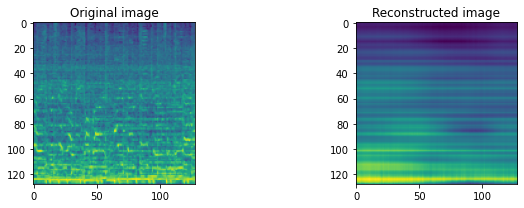

In [264]:

test_img = prediction_gen.take(12)[0]
prediction = autoencoder2(test_img)

plot_reconstruction(test_img, prediction, 1)

In [269]:
autoencoder_path = 'data/autoencoder_128dim_Conv1d_1'
autoencoder2.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_128dim_Conv1d_1/assets


INFO:tensorflow:Assets written to: data/autoencoder_128dim_Conv1d_1/assets


In [266]:
kernel_size = 5

class Autoencoder3(tf.keras.Model):
    
    def __init__(self, latent_dim, num_channels):
        super(Autoencoder3, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Reshape(target_shape=(128,128)),
            tf.keras.layers.Conv1D(input_shape=(img_height, img_width), filters=256, kernel_size=3, padding="same", strides=1, activation='relu'),
            tf.keras.layers.MaxPool1D(pool_size=2),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", strides=1, activation='relu'),
            tf.keras.layers.MaxPool1D(pool_size=2),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", strides=1, activation='relu'),
            tf.keras.layers.MaxPool1D(pool_size=2),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(2048, activation='relu'),
            Dense(units=latent_dim)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(2048, activation='relu'),
            Dense(units=8192, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(16,512)),
            tf.keras.layers.UpSampling1D(size=2),
            tf.keras.layers.Conv1DTranspose(filters=512, kernel_size=3, strides=1, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            tf.keras.layers.UpSampling1D(size=2),
            tf.keras.layers.Conv1DTranspose(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            tf.keras.layers.UpSampling1D(size=2),
            tf.keras.layers.Conv1DTranspose(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1DTranspose(filters=img_width, kernel_size=3, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder3 = Autoencoder3(128, 1)

opt = Adam(learning_rate=1e-3)

autoencoder3.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [270]:
hist = autoencoder3.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=10,
                       validation_data=data_gen.test)

Epoch 1/10
1531/1531 [==============================] - 483s 315ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 2/10
1531/1531 [==============================] - 500s 327ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 3/10
1531/1531 [==============================] - 520s 339ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 4/10
1531/1531 [==============================] - 549s 358ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 5/10
1531/1531 [==============================] - 591s 386ms/step - loss: 0.0078 - val_loss: 0.0107
Epoch 6/10
1531/1531 [==============================] - 502s 328ms/step - loss: 0.0075 - val_loss: 0.0309
Epoch 7/10
1531/1531 [==============================] - 413s 269ms/step - loss: 0.0075 - val_loss: 0.0971
Epoch 8/10
1531/1531 [==============================] - 403s 263ms/step - loss: 0.0075 - val_loss: 0.0164
Epoch 9/10
1531/1531 [==============================] - 390s 255ms/step - loss: 0.0073 - val_loss: 0.0109
Epoch 10/10
1531/1531 [=======================

In [271]:
autoencoder_path = 'data/autoencoder_128dim_Conv1d_2'
autoencoder3.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_128dim_Conv1d_2/assets


INFO:tensorflow:Assets written to: data/autoencoder_128dim_Conv1d_2/assets


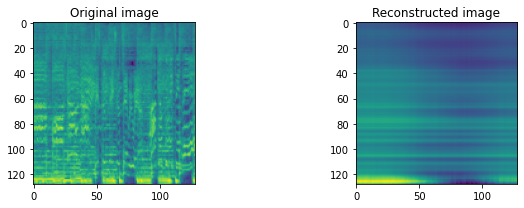

In [277]:

test_img = prediction_gen.take(10)[0]
prediction = autoencoder3(test_img)

plot_reconstruction(test_img, prediction, 1)

In [519]:
class Autoencoder4(tf.keras.Model):
    
    def __init__(self, latent_dim, num_channels):
        super(Autoencoder4, self).__init__()
        self.latent_dim = latent_dim
        self.time_encoder = Sequential([
            Reshape(target_shape=(128,128)),
            tf.keras.layers.Conv1D(input_shape=(img_height, img_width), filters=64, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(2048, activation='relu'),
            Dense(units=latent_dim//2)
        ])
        self.freq_encoder = Sequential([
            Reshape(target_shape=(128,128)),
            tf.keras.layers.Conv1D(input_shape=(img_height, img_width), filters=64, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding="same", strides=2, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(2048, activation='relu'),
            Dense(units=latent_dim//2)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=16384, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(8,8,256)),
            Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=5,  strides=2, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=5,  strides=2, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=num_channels, kernel_size=5, padding="same", activation='sigmoid'),
        ])
        
    def encoder(self, x):
        x_1 = x
        x_2 = tf.transpose(x, perm=[0,2,1,3])
        encoded_time = self.time_encoder(x_1)
        encoded_freq = self.freq_encoder(x_2)
        encoded = tf.keras.layers.Concatenate(axis=1)([encoded_time, encoded_freq])
        return encoded
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder4 = Autoencoder4(512, 1)

opt = Adam(learning_rate=1e-3)

autoencoder4.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [520]:
for layer in autoencoder4.layers:
    print(layer.summary())

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [534]:
hist = autoencoder4.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=100,
                       validation_data=data_gen.test)

Epoch 1/100
25/25 [==============================] - 16s 656ms/step - loss: 0.0068 - val_loss: 0.0104
Epoch 2/100
25/25 [==============================] - 16s 653ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 3/100
25/25 [==============================] - 17s 670ms/step - loss: 0.0068 - val_loss: 0.0115
Epoch 4/100
25/25 [==============================] - 16s 653ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 5/100
25/25 [==============================] - 17s 661ms/step - loss: 0.0069 - val_loss: 0.0454
Epoch 6/100
25/25 [==============================] - 16s 655ms/step - loss: 0.0068 - val_loss: 0.0876
Epoch 7/100
25/25 [==============================] - 16s 655ms/step - loss: 0.0069 - val_loss: 0.0183
Epoch 8/100
 9/25 [=========>....................] - ETA: 9s - loss: 0.0067

KeyboardInterrupt: 

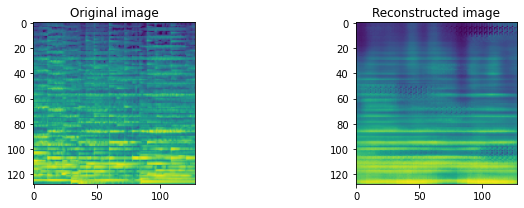

In [536]:
test_img = data_gen.take(16)[0]
prediction = autoencoder4(test_img)

plot_reconstruction(test_img, prediction, 1)